In [54]:
!pip install efficientnet

     |████████████████████████████████| 50 kB 5.0 MB/s eta 0:00:011


In [55]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications import Xception, VGG16, VGG19, ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2
import efficientnet.tfkeras as efn


import requests

In [29]:
def telegram_bot_sendtext(bot_message):
    bot_token = '1653403779:AAFxxs8vLirSm-nXejEvmHpBoASuZOO75D8'
    bot_chatID = '1589422433'
    send_text = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + \
                '&parse_mode=MarkdownV2&text=' + bot_message
    response = requests.get(send_text)
    
    return response.json

In [30]:
data_dir = '../data/layer'

In [36]:
batch_size = 256
img_height = 256
img_width = 256

In [37]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18124 files belonging to 10 classes.
Using 14500 files for training.


In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18124 files belonging to 10 classes.
Using 3624 files for validation.


In [39]:
class_names = train_ds.class_names
print(class_names)

['bacterial_spot', 'early_blight', 'healthy', 'late_blight', 'leaf_mold', 'leaf_septoria', 'mosaic_virus', 'spider_mites', 'target_spot', 'yellow_leaf_curl_virus']


In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [41]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [42]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [43]:
num_classes = 10

In [44]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [56]:
efficient = efn.EfficientNetB0(weights='imagenet', include_top=False, 
                       input_shape=(256, 256, 3))

for layer in efficient.layers[:]:
    layer.trainable = False

16809984/16804768 [==============================] - 1s 0us/step


In [57]:
model = Sequential([
  data_augmentation,
  efficient,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding = 'same', activation = 'relu'),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dropout(0.2),  
  layers.Dense(num_classes)
])

In [58]:
opt = keras.optimizers.Adam(learning_rate=0.0005)

In [59]:
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 8, 8, 1280)        4049564   
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 8, 8, 1280)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 16)          184336    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 32)          4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 2, 32)         

In [ ]:
epochs = 11
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

telegram_bot_sendtext('done')

Epoch 1/11
57/57 [==============================] - 407s 7s/step - loss: 2.2184 - accuracy: 0.2452 - val_loss: 2.1523 - val_accuracy: 0.2969
Epoch 2/11
57/57 [==============================] - 393s 7s/step - loss: 2.1096 - accuracy: 0.3044 - val_loss: 2.1484 - val_accuracy: 0.2961
Epoch 3/11
57/57 [==============================] - 394s 7s/step - loss: 2.0992 - accuracy: 0.2882 - val_loss: 2.1070 - val_accuracy: 0.2977
Epoch 4/11
57/57 [==============================] - 394s 7s/step - loss: 2.0632 - accuracy: 0.3018 - val_loss: 2.0979 - val_accuracy: 0.2994
Epoch 5/11
57/57 [==============================] - 397s 7s/step - loss: 2.0405 - accuracy: 0.2999 - val_loss: 2.0908 - val_accuracy: 0.2991
Epoch 6/11
21/57 [==========>...................] - ETA: 3:24 - loss: 2.0120 - accuracy: 0.3052

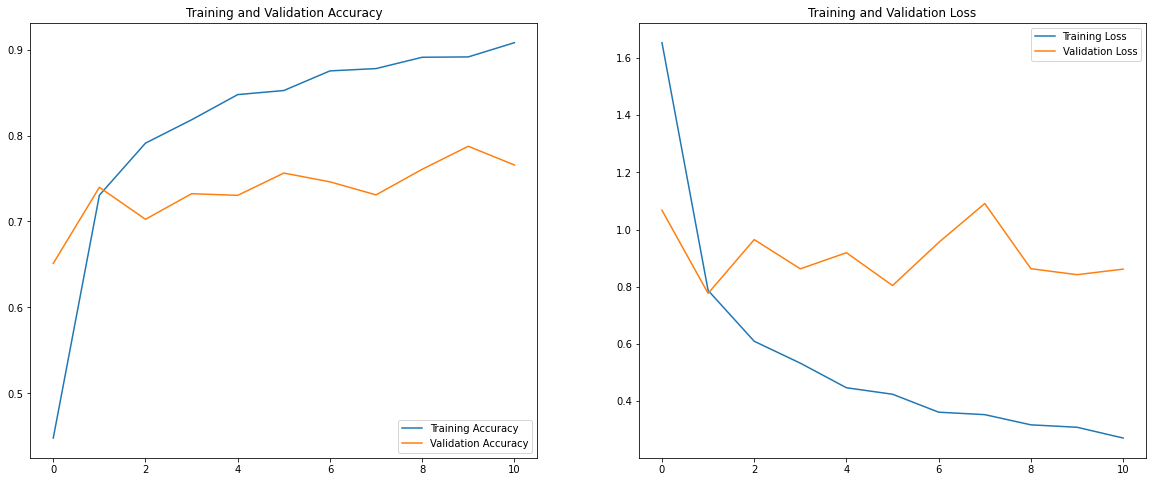

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()